# Image Classification using VGG16_BN 

In [1]:
# install dependencies and packages
!pip install torch torchvision scikit-learn cnn_finetune



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\krain\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# cnn_finetune imports caused problems, using torchvision directly instead
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#os.environ["TORCHDYNAMO_DISABLE"] = "1"

A custom Dataset class is created to load the coral images from the file paths HEALTHY_IMAGES_DIR and BLEACHED_IMAGES_DIR.
The subfolders contain images of healthy and bleached corals.

The dataset used is from Kaggle: https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification/data

Dataset Details:
+ Total images: 923
+ Image categories: 2
    + Healthy corals: 438 images
    + Bleached corals: 485 images
+ Image format: JPEG
+ Image size: Maximum 300 px for either width or height, whichever is higher


In [3]:
# prepare coral dataset

class CoralDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label
    
    
HEALTHY_IMAGES_DIR = "data/healthy_corals"
BLEACHED_IMAGES_DIR = "data/bleached_corals"

# imagepaths and labels
healthy_image_paths = [os.path.join(HEALTHY_IMAGES_DIR, img) for img in os.listdir(HEALTHY_IMAGES_DIR) if os.path.isfile(os.path.join(HEALTHY_IMAGES_DIR, img))]
bleached_image_paths = [os.path.join(BLEACHED_IMAGES_DIR, img) for img in os.listdir(BLEACHED_IMAGES_DIR) if os.path.isfile(os.path.join(BLEACHED_IMAGES_DIR, img))]

image_paths = healthy_image_paths + bleached_image_paths
labels = [0] * len(healthy_image_paths) + [1] * len(bleached_image_paths)

The datasets is splitted into training (80%), validation (10%) and testing (10%).
Training data is used for model learning, the validation data evaluates the performance during training and the data assesses the final model performance.

In [4]:
# split dataset into training (80%), validation (10%) and testing (10%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

print('Dataset was successfully split into training, validation, and testing sets')

Dataset was successfully split into training, validation, and testing sets


Image data is preprocessed for training, to make the model more robust:
* Images are resized to 224x224 pixels, this matches the expected intput size for the VGG16 model.
* Images are converted from a PIL format to PyTorch tensor, because PyTorch models operate on tensors and not images.
* Pixel intensity values are adjusted to match the mean and standard deviation of the ImageNet dataset. VGG16 is pretrained on ImageNet and expects input data with similar statistics, otherwise the trianing migth be unstable or converge slowly
* Images are randomly flipped horizontally to generalize models for features that are horizontally symmetric.
* The brightness and contrast of the images is randomly adjusted to help with lighting variations
* Images are randomly rotated by +- 10 degrees to simulate real world situations and different angles

In [5]:
# define data transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
   #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #transforms.RandomRotation(10)
])

Datasets are created using the data tranformations which were previously defined.

Dataloaders are created to feed the data to the model in batches to make the training more efficient.

In [6]:
# create Datasets
train_dataset = CoralDataset(train_paths, train_labels, transform=data_transforms)
val_dataset = CoralDataset(val_paths, val_labels, transform=data_transforms)
test_dataset = CoralDataset(test_paths, test_labels, transform=data_transforms)

# create Dataloader for each Dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


For verification an better understanding the image transformations are visualized using five random images from the training dataset.

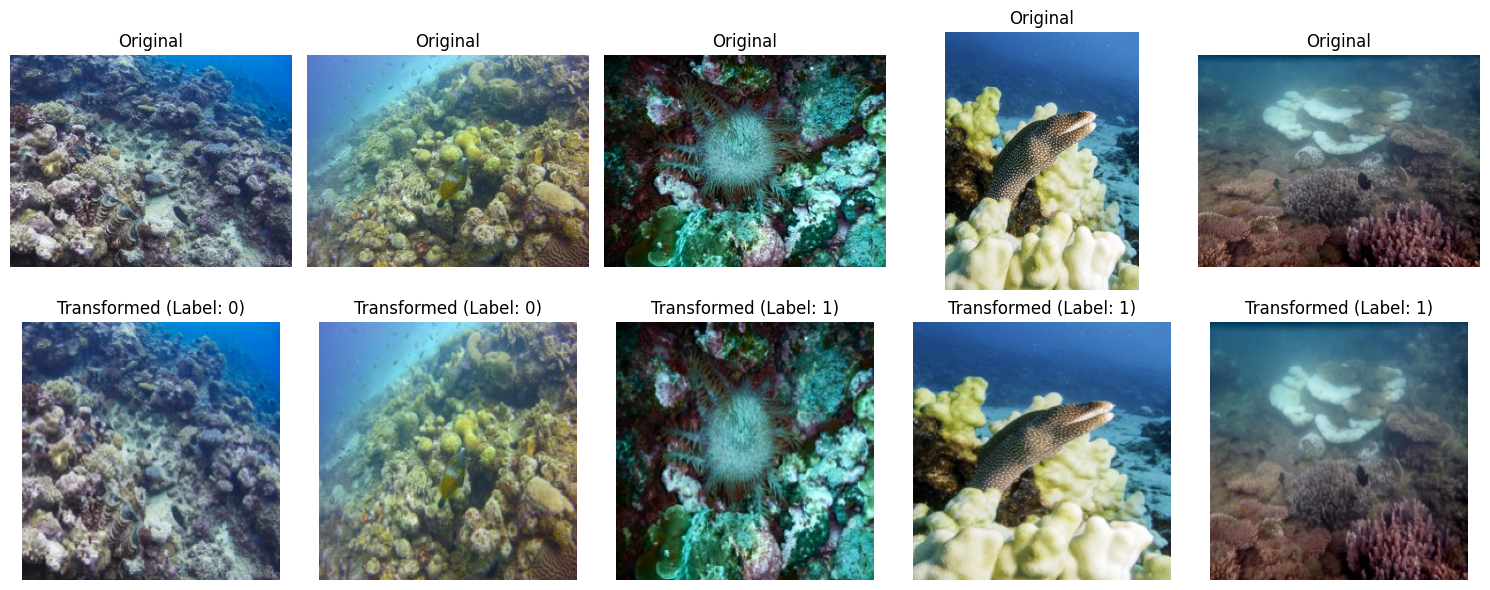

In [7]:
# Visualize original and transformed images one above the other
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns (original and transformed)

# Function to denormalize images for visualization
def denormalize(image, mean, std):
    mean = np.array(mean).reshape(1, 1, 3)
    std = np.array(std).reshape(1, 1, 3)
    image = image.numpy().transpose((1, 2, 0))  # Convert from tensor (C, H, W) to (H, W, C)
    image = std * image + mean  # Undo normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1]
    return image

# Define mean and std (same as used in transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Disable shuffling temporarily
temp_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)

# Fetch a small batch of images and labels
data_iter = iter(temp_loader)
images, labels = next(data_iter)

for i in range(5):  # Show 5 images
    # Load the original image directly using the same index
    img_path = train_paths[i]  # Ensure train_paths is accessible
    original_image = Image.open(img_path).convert('RGB')
    
    # Plot the original image
    axes[0, i].imshow(original_image)
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")
    
    # Plot the transformed image
    transformed_image = denormalize(images[i], mean, std)
    axes[1, i].imshow(transformed_image)
    axes[1, i].set_title(f"Transformed (Label: {labels[i].item()})")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()



The VGG16 model is loaded with pretrained weights. Pre-trained weights provide a strong starting point, especially useful for smaller datasets.

The classifier is modified by replacing the final fully connected layer with one having out_features=2 for binary classification (healthy vs. bleached corals)

In [8]:
# create model and adapt it to coral Dataset
model = models.vgg16_bn(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

# move model to the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\krain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\krain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For the Loss Function ```nn.CrossEntropyLoss``` because it is suitable for multi-class classification problems 

For the Optimizer Adam is chosen. Other optimizers like SGD can be used aswell to evaluate the performance.

A scheduler is used to adjust the learning rate dynamically during training to optimize the learning process.

In [9]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

**Model Training:**

The dataset is looped through ```num_epochs```times, training the model with backpropagation.
During the training the images and labels are moved to the GPU, gradients are resetted ```optimizer.zero_grad()```, the predictions are computed, loss is calculated and the model weights are updated. 

During the model evaluation the labels for the test data are predicted and the fraction of correct predictions is calculated.


In [11]:
# train model
num_epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # average loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')
    
    # reduce the learning rate based on step_size
    scheduler.step()
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}") 
    
    # validate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

print('Training completed')


KeyboardInterrupt: 

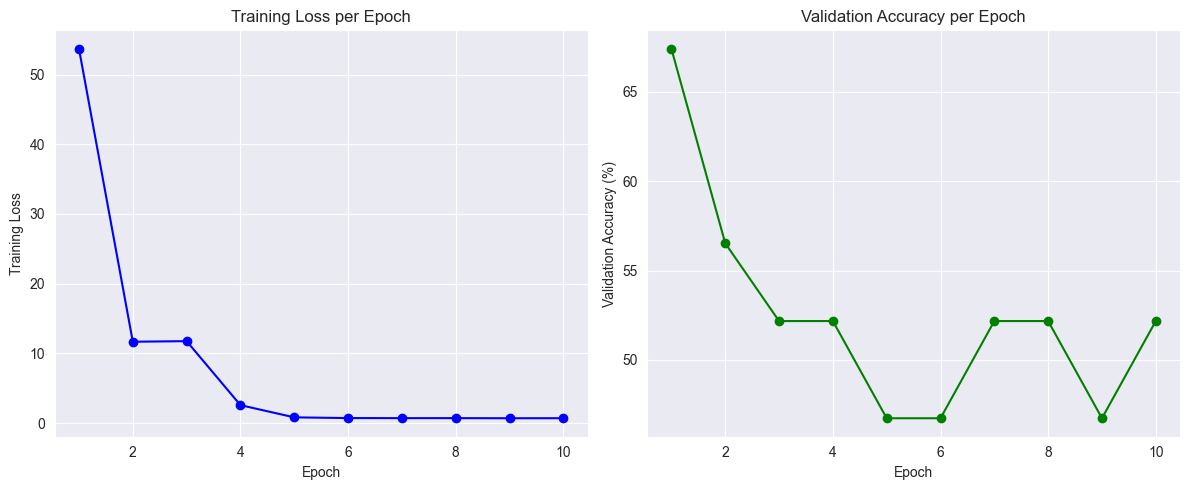

In [11]:
# visualize outcome
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')

# plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', color='g')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy per Epoch')

plt.tight_layout()
plt.show()

### Comparison of four runs with adapted parameters

Here is the final combined test plan for all 4 runs, with adjustments made to display `1e-4` as a decimal value:

---

### **Test Plan for 4 Runs**

| **Run** | **Batch Size** | **Learning Rate (LR)** | **Augmentation**                           | **Scheduler Step Size** | **Epochs** | **Why Test These Values?**                                                                          |
|---------|----------------|-------------------------|-------------------------------------------|--------------------------|-------------|-----------------------------------------------------------------------------------------------------|
| **1**   | 32             | 0.001                  | Resize, Normalize                         | 5                        | 30          | Baseline values to establish the model's performance.                                               |
| **2**   | 64             | 0.0001                 | Resize, Normalize, Horizontal Flip        | 10                       | 50          | Larger batch size for more stable training and longer epochs for better convergence.                |
| **3**   | 16             | 0.0005                 | Resize, Normalize, Rotation (15°)         | 5                        | 30          | Smaller batch size for better generalization, higher LR for faster optimization.                    |
| **4**   | 48             | 0.0002                 | Resize, Normalize, Horizontal Flip + Rotation (10°) | 8                        | 40          | Balanced batch size and learning rate to test trade-offs between stability and faster learning.     |

---

### **Why Test These Values?**

#### **1. Batch Size**
- **Why vary?**
  - Larger batch sizes stabilize training and speed up convergence.
  - Smaller batch sizes promote generalization and help the model escape local minima.
- **What do we expect?**
  - Larger batch sizes (e.g., 64) might improve validation accuracy for simpler datasets.
  - Smaller batch sizes (e.g., 16) could generalize better for complex data or imbalanced classes.

#### **2. Learning Rate (LR)**
- **Why vary?**
  - The learning rate determines the speed of optimization.
  - Smaller learning rates (e.g., `0.0001`) are more precise but slower.
  - Moderate learning rates (e.g., `0.001`) enable faster learning but can be unstable.
  - Higher learning rates (e.g., `0.0005`) help the model converge quickly but may overshoot the minimum.
- **What do we expect?**
  - A smaller learning rate might perform better with complex models or longer training durations.

#### **3. Augmentation**
- **Why vary?**
  - Augmentation makes the model more robust and reduces overfitting.
  - Horizontal flips simulate symmetry in the data (e.g., coral images).
  - Rotation helps with images where orientation varies.
- **What do we expect?**
  - Augmentation should improve validation accuracy, especially for small datasets.

#### **4. Scheduler Step Size**
- **Why vary?**
  - The scheduler step size controls how often the learning rate is reduced.
  - A shorter step size (e.g., 5) allows for earlier adjustments.
  - A longer step size (e.g., 10) allows more training at the original learning rate.
- **What do we expect?**
  - Shorter step sizes can help with unstable loss functions.
  - Longer step sizes may benefit stable loss curves.

#### **5. Epochs**
- **Why vary?**
  - More epochs give the model more time to learn but increase the risk of overfitting.
- **What do we expect?**
  - More epochs (e.g., 50) should work well with lower learning rates and larger batch sizes.
  - Fewer epochs (e.g., 30) are suitable for faster optimization.

---

### **Metrics to Track During Runs**

| **Metric**            | **Description**                                                                                  | **Goal**                                                                                     |
|------------------------|--------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|
| **Training Loss**      | Measures the model's error on the training data.                                                | Should steadily decrease. High values indicate underfitting.                                |
| **Validation Loss**    | Measures the model's error on the validation data.                                              | Should decrease but not rise. Increasing validation loss alongside decreasing training loss indicates overfitting. |
| **Validation Accuracy**| Measures the percentage of correct predictions on the validation data.                          | Should increase. Low values indicate poor generalization.                                   |
| **Training Time**      | Time taken for each run.                                                                        | Longer times expected for larger batch sizes or more epochs.                                |

---

### **Result Table After Each Run**

| **Run** | **Final Training Loss** | **Final Validation Loss** | **Final Validation Accuracy** | **Training Time (min)** |
|---------|--------------------------|----------------------------|-------------------------------|-------------------------|
| 1       |                          |                            |                               |                         |
| 2       |                          |                            |                               |                         |
| 3       |                          |                            |                               |                         |
| 4       |                          |                            |                               |                         |

---

### **Conclusion**

   - Identify which run achieves the best validation accuracy and lowest validation loss.
   - Compare training loss to validation loss to check for overfitting.
   - Analyze the effect of augmentations, batch size, and learning rate on performance.


